In [1]:
!pip install tclab

In [3]:
# GRAPHICAL FOPDT MODEL FIT #

import numpy as np
import pandas as pd
import scipy
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import ipywidgets as wg
from IPython.display import display

# try to read local data file first
try:
    filename = 'datos2Q.csv'
    data = pd.read_csv(filename)
except:
    filename = 'http://apmonitor.com/pdc/uploads/Main/tclab_data2.txt'
    data = pd.read_csv(filename)

n = 601 # time points to plot
tf = 600.0 # final time

# Use expected room temperature for initial condition
#y0 = [23.0,23.0]
# Use initial condition
y0d = [data['T1'].values[0],data['T2'].values[0]]

# load data
Q1 = data['Q1'].values
Q2 = data['Q2'].values
T1 = data['T1'].values
T2 = data['T2'].values
T1p = np.ones(n)*y0d[0]
T2p = np.ones(n)*y0d[1]

def process(y,t,u1,u2,Kp,Kd,taup):
    y1,y2 = y
    dy1dt = (1.0/taup) * (-(y1-y0d[0]) + Kp * u1 + Kd * (y2-y1))
    dy2dt = (1.0/taup) * (-(y2-y0d[1]) + (Kp/2.0) * u2 + Kd * (y1-y2))
    return [dy1dt,dy2dt]

def fopdtPlot(Kp,Kd,taup,thetap):
    y0 = y0d
    t = np.linspace(0,tf,n) # create time vector
    iae = 0.0
    # loop through all time steps
    for i in range(1,n):
        # simulate process for one time step
        ts = [t[i-1],t[i]]         # time interval
        inputs = (Q1[max(0,i-int(thetap))],Q2[max(0,i-int(thetap))],Kp,Kd,taup)
        y = odeint(process,y0,ts,args=inputs)
        y0 = y[1]                  # record new initial condition
        T1p[i] = y0[0]
        T2p[i] = y0[1]        
        iae += np.abs(T1[i]-T1p[i]) + np.abs(T2[i]-T2p[i])

    # plot FOPDT response
    plt.figure(1,figsize=(15,7))
    plt.subplot(2,1,1)
    plt.plot(t,T1,'r.',linewidth=2,label='Temperature 1 (meas)')
    plt.plot(t,T2,'b.',linewidth=2,label='Temperature 2 (meas)')
    plt.plot(t,T1p,'r--',linewidth=2,label='Temperature 1 (pred)')
    plt.plot(t,T2p,'b--',linewidth=2,label='Temperature 2 (pred)')
    plt.ylabel(r'T $(^oC)$')
    plt.text(200,20,'Integral Abs Error: ' + str(np.round(iae,2)))
    plt.text(400,35,r'$K_p$: ' + str(np.round(Kp,2)))  
    plt.text(400,30,r'$K_d$: ' + str(np.round(Kd,2)))  
    plt.text(400,25,r'$\tau_p$: ' + str(np.round(taup,0)) + ' sec')  
    plt.text(400,20,r'$\theta_p$: ' + str(np.round(thetap,0)) + ' sec')  
    plt.legend(loc=2)
    plt.subplot(2,1,2)
    plt.plot(t,Q1,'b--',linewidth=2,label=r'Heater 1 ($Q_1$)')
    plt.plot(t,Q2,'r:',linewidth=2,label=r'Heater 2 ($Q_2$)')
    plt.legend(loc='best')
    plt.xlabel('time (sec)')

Kp_slide = wg.FloatSlider(value=0.5,min=0.1,max=1.5,step=0.05)
Kd_slide = wg.FloatSlider(value=0.0,min=0.0,max=1.0,step=0.05)
taup_slide = wg.FloatSlider(value=50.0,min=50.0,max=250.0,step=5.0)
thetap_slide = wg.FloatSlider(value=0,min=0,max=30,step=1)
wg.interact(fopdtPlot, Kp=Kp_slide, Kd=Kd_slide, taup=taup_slide,thetap=thetap_slide)
print('FOPDT Simulator: Adjust Kp, Kd, taup, and thetap ' + \
      'to achieve lowest Integral Abs Error')

interactive(children=(FloatSlider(value=0.5, description='Kp', max=1.5, min=0.1, step=0.05), FloatSlider(value…

FOPDT Simulator: Adjust Kp, Kd, taup, and thetap to achieve lowest Integral Abs Error


Initial SSE Objective: 8480.215135052631
Optimizing Values...


C:\Users\creye\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Final SSE Objective: 487.12942659869736
Kp: 1.098079768413434
Kd: 0.3872031957560968
taup: 180.65670059133677
thetap: 16.23122246277403


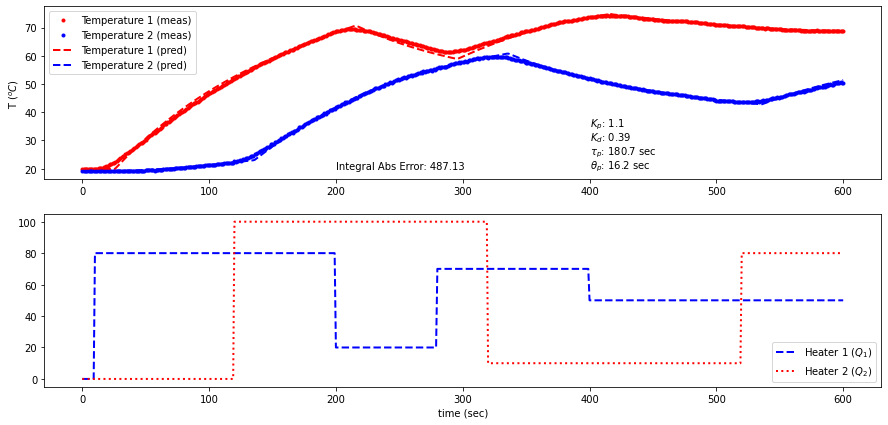

In [12]:
# Optimized FOPDT Model Fit #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# initial guesses
x0 = np.zeros(4)
x0[0] = 0.8 # Kp
x0[1] = 0.2 # Kd
x0[2] = 150.0 # taup
x0[3] = 10.0 # thetap

# Import CSV data file
# try to read local data file first
try:
    filename = 'data2Q.csv'
    data = pd.read_csv(filename)
except:
    filename = 'http://apmonitor.com/pdc/uploads/Main/tclab_data2.txt'
    data = pd.read_csv(filename)
Q1_0 = data['Q1'].values[0]
Q2_0 = data['Q2'].values[0]
T1_0 = data['T1'].values[0]
T2_0 = data['T2'].values[0]
t = data['Time'].values - data['Time'].values[0]
Q1 = data['Q1'].values
Q2 = data['Q2'].values
T1 = data['T1'].values
T2 = data['T2'].values

# specify number of steps
ns = len(t)
delta_t = t[1]-t[0]
# create linear interpolation of the u data versus time
Qf1 = interp1d(t,Q1)
Qf2 = interp1d(t,Q2)

# define first-order plus dead-time approximation    
def fopdt(T,t,Qf1,Qf2,Kp,Kd,taup,thetap):
    #  T      = states
    #  t      = time
    #  Qf1    = input linear function (for time shift)
    #  Qf2    = input linear function (for time shift)
    #  Kp     = model gain
    #  Kd     = disturbance gain
    #  taup   = model time constant
    #  thetap = model time constant
    # time-shift Q
    try:
        if (t-thetap) <= 0:
            Qm1 = Qf1(0.0)
            Qm2 = Qf2(0.0)
        else:
            Qm1 = Qf1(t-thetap)
            Qm2 = Qf2(t-thetap)
    except:
        Qm1 = Q1_0
        Qm2 = Q2_0
    # calculate derivative
    dT1dt = (-(T[0]-T1_0) + Kp*(Qm1-Q1_0) + Kd*(T[1]-T[0]))/taup
    dT2dt = (-(T[1]-T2_0) + (Kp/2.0)*(Qm2-Q2_0) + Kd*(T[0]-T[1]))/taup
    return [dT1dt,dT2dt]

# simulate FOPDT model
def sim_model(x):
    # input arguments
    Kp,Kd,taup,thetap = x
    # storage for model values
    T1p = np.ones(ns) * T1_0
    T2p = np.ones(ns) * T2_0
    # loop through time steps    
    for i in range(0,ns-1):
        ts = [t[i],t[i+1]]
        T = odeint(fopdt,[T1p[i],T2p[i]],ts,args=(Qf1,Qf2,Kp,Kd,taup,thetap))
        T1p[i+1] = T[-1,0]
        T2p[i+1] = T[-1,1]
    return T1p,T2p

# define objective
def objective(x):
    # simulate model
    T1p,T2p = sim_model(x)
    # return objective
    return sum(np.abs(T1p-T1)+np.abs(T2p-T2))

# show initial objective
print('Initial SSE Objective: ' + str(objective(x0)))
print('Optimizing Values...')

# optimize without parameter constraints
#solution = minimize(objective,x0)

# optimize with bounds on variables
bnds = ((0.4, 1.5), (0.1, 0.5), (50.0, 200.0), (0.0, 30.0))
solution = minimize(objective,x0,bounds=bnds,method='SLSQP')

# show final objective
x = solution.x
iae = objective(x)
Kp,Kd,taup,thetap = x
print('Final SSE Objective: ' + str(objective(x)))
print('Kp: ' + str(Kp))
print('Kd: ' + str(Kd))
print('taup: ' + str(taup))
print('thetap: ' + str(thetap))
# save fopdt.txt file
fid = open('fopdt.txt','w')
fid.write(str(Kp)+'\n')
fid.write(str(Kd)+'\n')
fid.write(str(taup)+'\n')
fid.write(str(thetap)+'\n')
fid.write(str(T1_0)+'\n')
fid.write(str(T2_0)+'\n')
fid.close()

# calculate model with updated parameters
T1p,T2p = sim_model(x)

plt.figure(1,figsize=(15,7))
plt.subplot(2,1,1)
plt.plot(t,T1,'r.',linewidth=2,label='Temperature 1 (meas)')
plt.plot(t,T2,'b.',linewidth=2,label='Temperature 2 (meas)')
plt.plot(t,T1p,'r--',linewidth=2,label='Temperature 1 (pred)')
plt.plot(t,T2p,'b--',linewidth=2,label='Temperature 2 (pred)')
plt.ylabel(r'T $(^oC)$')
plt.text(200,20,'Integral Abs Error: ' + str(np.round(iae,2)))
plt.text(400,35,r'$K_p$: ' + str(np.round(Kp,2)))  
plt.text(400,30,r'$K_d$: ' + str(np.round(Kd,2)))  
plt.text(400,25,r'$\tau_p$: ' + str(np.round(taup,1)) + ' sec')  
plt.text(400,20,r'$\theta_p$: ' + str(np.round(thetap,1)) + ' sec')  
plt.legend(loc=2)
plt.subplot(2,1,2)
plt.plot(t,Q1,'b--',linewidth=2,label=r'Heater 1 ($Q_1$)')
plt.plot(t,Q2,'r:',linewidth=2,label=r'Heater 2 ($Q_2$)')
plt.legend(loc='best')
plt.xlabel('time (sec)')
plt.show()

In [4]:
#Test Dual Heater Physics-based Model MATLAB C:\Users\creye\OneDrive\Escritorio\TEST\tclab_matlab_gendata

In [ ]:
#Energy balance parameter estimation

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# Import CSV data file
# Column 1 = time (t)
# Column 2 = input (u)
# Column 3 = output (yp)
data = np.loadtxt('data2Q.txt',delimiter=',',skiprows=1)
u0 = data[0,1]
yp0 = data[0,3]
t = data[:,0].T - data[0,0]
u = data[:,1].T
yp = data[:,3].T

# specify number of steps
ns = len(t)
delta_t = t[1]-t[0]
# create linear interpolation of the u data versus time
uf = interp1d(t,u)

# define first-order plus dead-time approximation    
def fopdt(y,t,uf,Km,taum,thetam):
    # arguments
    #  y      = output
    #  t      = time
    #  uf     = input linear function (for time shift)
    #  Km     = model gain
    #  taum   = model time constant
    #  thetam = model time constant
    # time-shift u
    try:
        if (t-thetam) <= 0:
            um = uf(0.0)
        else:
            um = uf(t-thetam)
    except:
        #print('Error with time extrapolation: ' + str(t))
        um = u0
    # calculate derivative
    dydt = (-(y-yp0) + Km * (um-u0))/taum
    return dydt

# simulate FOPDT model with x=[Km,taum,thetam]
def sim_model(x):
    # input arguments
    Km = x[0]
    taum = x[1]
    thetam = x[2]
    # storage for model values
    ym = np.zeros(ns)  # model
    # initial condition
    ym[0] = yp0
    # loop through time steps    
    for i in range(0,ns-1):
        ts = [t[i],t[i+1]]
        y1 = odeint(fopdt,ym[i],ts,args=(uf,Km,taum,thetam))
        ym[i+1] = y1[-1]
    return ym

# define objective
def objective(x):
    # simulate model
    ym = sim_model(x)
    # calculate objective
    obj = 0.0
    for i in range(len(ym)):
        obj = obj + (ym[i]-yp[i])**2    
    # return result
    return obj

# initial guesses
x0 = np.zeros(3)
x0[0] = 0.5 # Km
x0[1] = 120.0 # taum
x0[2] = 0.0 # thetam

# show initial objective
print('Initial SSE Objective: ' + str(objective(x0)))

# optimize Km, taum, thetam
solution = minimize(objective,x0)

# Another way to solve: with bounds on variables
#bnds = ((0.4, 0.6), (1.0, 10.0), (0.0, 30.0))
#solution = minimize(objective,x0,bounds=bnds,method='SLSQP')
x = solution.x

# show final objective
print('Final SSE Objective: ' + str(objective(x)))

print('Kp: ' + str(x[0]))
print('taup: ' + str(x[1]))
print('thetap: ' + str(x[2]))

# calculate model with updated parameters
ym1 = sim_model(x0)
ym2 = sim_model(x)
# plot results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,yp,'kx-',linewidth=2,label='Process Data')
plt.plot(t,ym1,'b-',linewidth=2,label='Initial Guess')
plt.plot(t,ym2,'r--',linewidth=3,label='Optimized FOPDT')
plt.ylabel('Output')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(t,u,'bx-',linewidth=2)
plt.plot(t,uf(t),'r--',linewidth=3)
plt.legend(['Measured','Interpolated'],loc='best')
plt.ylabel('Input Data')
plt.savefig('fopdt_fit.png')
plt.show()

Initial SSE Objective: 88696.32418809726
